## General idea: cluster artists together based on aggregated audio features of their songs
* try transforming features before aggregating
* try including sd, 25th quantile, 75th quantile as features
* incorporate number of days, show results of clustering group by showing artist in group in descending order of popularity

In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter(indent=4)

## Setup

In [2]:
#get total number of days for each song
all_df = pd.read_csv("TopCharts_complete.csv").dropna()
df = all_df.drop_duplicates(subset = ['uri']).copy()
days_count = all_df.pivot_table(index = ['uri'], aggfunc='size')
for uri in days_count.index:
    df.loc[df.uri == uri, 'days'] = days_count[uri]
df.head()

,rank,date,artist,title,streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,days
0,1,2017-01-01,Migos,Bad and Boujee (feat. Lil Uzi Vert),"1,371,493",0.927,0.665,11.0,-5.313,1.0,0.2440,0.061,0.000000,0.123,0.175,127.076,spotify:track:4Km5HrUvYTaSUfiSGPJeQR,343150.0,4.0,429.0
1,2,2017-01-01,Drake,Fake Love,"1,180,074",0.928,0.481,9.0,-9.350,0.0,0.2870,0.105,0.000000,0.176,0.613,134.007,spotify:track:343YBumqHu19cGoGARUTsd,210937.0,4.0,455.0
2,3,2017-01-01,The Weeknd,Starboy,"1,064,351",0.679,0.587,7.0,-7.015,1.0,0.2760,0.141,0.000006,0.137,0.486,186.003,spotify:track:7MXVkk9YMctZqd1Srtv4MB,230453.0,4.0,464.0
3,4,2017-01-01,The Chainsmokers,Closer,"1,010,492",0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.000000,0.111,0.661,95.010,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,244960.0,4.0,536.0
4,5,2017-01-01,Rae Sremmurd,Black Beatles,"874,289",0.794,0.632,0.0,-6.163,1.0,0.0649,0.142,0.000000,0.128,0.355,145.926,spotify:track:6fujklziTHa8uoM5OQSfIo,291893.0,4.0,240.0


In [3]:
df.to_csv("TopCharts_days.csv")

In [4]:
#cluster only on continuous features
cluster_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

In [6]:
artist_dict = {'artist': [], 'days' : []}
a1 = {"median " + c:[] for c in cluster_cols}
artist_dict.update(a1)
unique_artists = df.artist.unique()
for a in unique_artists:
    subset = df.loc[df.artist == a, :]
    artist_dict['days'].append(subset['days'].sum())
    artist_dict['artist'].append(a)
    for k in cluster_cols:
        artist_dict['median ' + k].append(subset[k].median())

In [7]:
df_artist = pd.DataFrame(artist_dict)
df_artist.head()

,artist,days,median danceability,median energy,median loudness,median speechiness,median acousticness,median instrumentalness,median liveness,median valence,median tempo
0,Migos,3227.0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.000000,0.1325,0.3505,137.4800
1,Drake,6877.0,0.7200,0.5370,-7.7055,0.17350,0.11600,0.000002,0.1225,0.3525,118.9900
2,The Weeknd,2926.0,0.5600,0.6110,-7.0150,0.06410,0.13100,0.000023,0.1250,0.2520,119.8290
3,The Chainsmokers,2577.0,0.6160,0.6285,-6.6005,0.04265,0.05865,0.000000,0.1505,0.3980,104.4755
4,Rae Sremmurd,1147.0,0.8030,0.6320,-5.1930,0.06490,0.05440,0.000001,0.1110,0.2640,131.9860


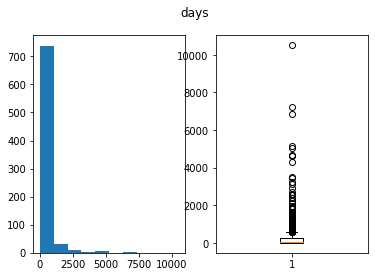

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df_artist.days)
ax2.boxplot(df_artist.days)
fig.suptitle("days")
plt.show()

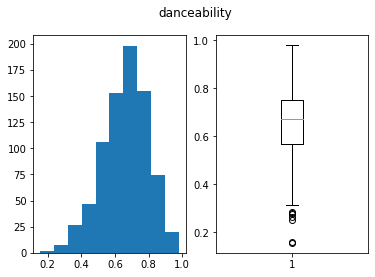

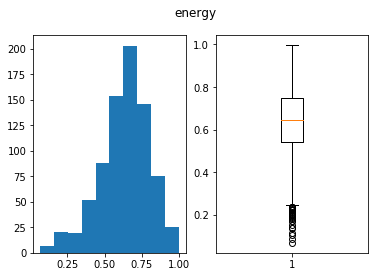

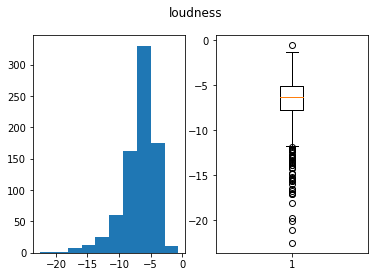

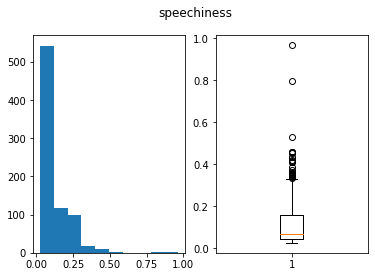

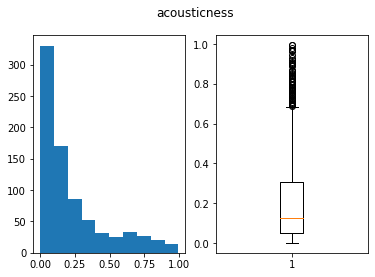

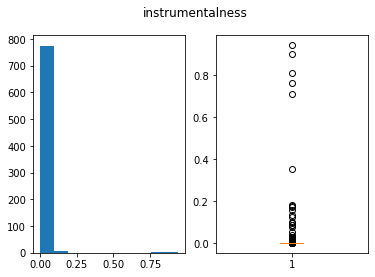

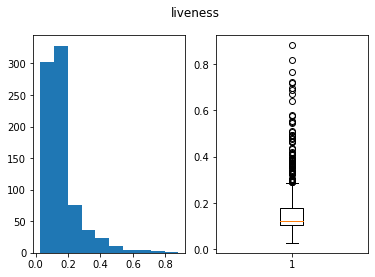

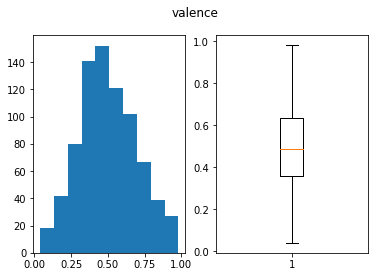

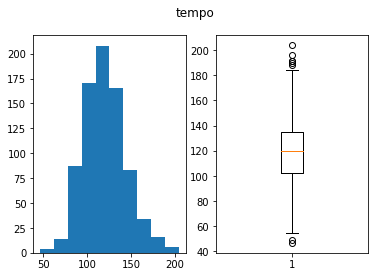

In [10]:
for k in cluster_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    data = artist_dict["median " + k]
    ax1.hist(data)
    ax2.boxplot(data)
    fig.suptitle(k)
    plt.show()

In [4]:
# from scipy.stats import boxcox
# temp = df.copy()
# temp.loc[:,'spechiness'] = boxcox(temp.speechiness)[0]
# temp.loc[:,'acousticness'] = boxcox(temp.acousticness)[0]
# temp.loc[:,'liveness'] = np.log(temp.liveness)
# t_artist_dict = {c:[] for c in ['artist'] + cluster_cols}
# t_unique_artists = df.artist.unique()
# for a in t_unique_artists:
#     t_artist_dict['artist'].append(a)
#     for k in cluster_cols:
#         t_artist_dict[k].append(temp.loc[temp.artist == a, k].median())
# temp_df_artist = pd.DataFrame(t_artist_dict)
# print(temp_df_artist.head())
# for k in temp_df_artist.columns[1:]:
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.hist(temp_df_artist[k])
#     ax2.boxplot(temp_df_artist[k])
#     fig.suptitle(f"dist. of median {k}")
#     plt.show()

In [11]:
#vast majority of values for instrumentalness at 0; non-discriminatory feature, can drop
df_artist.drop(columns = ['median instrumentalness'], inplace = True)

## Transform + scale data

In [17]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [12]:
cluster_cols = df_artist.columns[2:]
cluster_cols

Index(['median danceability', 'median energy', 'median loudness',
       'median speechiness', 'median acousticness', 'median liveness',
       'median valence', 'median tempo'],
      dtype='object')

In [13]:
X = df_artist[cluster_cols]

In [14]:
X

,median danceability,median energy,median loudness,median speechiness,median acousticness,median liveness,median valence,median tempo
0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.1325,0.3505,137.4800
1,0.7200,0.5370,-7.7055,0.17350,0.11600,0.1225,0.3525,118.9900
2,0.5600,0.6110,-7.0150,0.06410,0.13100,0.1250,0.2520,119.8290
3,0.6160,0.6285,-6.6005,0.04265,0.05865,0.1505,0.3980,104.4755
4,0.8030,0.6320,-5.1930,0.06490,0.05440,0.1110,0.2640,131.9860
...,...,...,...,...,...,...,...,...
784,0.5600,0.9360,-5.8350,0.04390,0.00847,0.1610,0.3710,112.9600
785,0.5850,0.2770,-14.2310,0.03180,0.67000,0.1140,0.4810,140.6660
786,0.6930,0.2590,-7.9180,0.03720,0.44800,0.0995,0.3610,88.9720
787,0.5790,0.7140,-4.4550,0.03640,0.01360,0.1110,0.3580,119.8940


In [18]:
def scale(X):
    X_scaled = X.copy()    
    scaled_values = RobustScaler().fit_transform(X)
    
    for i in range(scaled_values.shape[1]):
        X_scaled.iloc[:,i] = scaled_values[:,i]

    return X_scaled

In [19]:
X_scaled = scale(X)
X_scaled

,median danceability,median energy,median loudness,median speechiness,median acousticness,median liveness,median valence,median tempo
0,0.898907,0.112195,0.228545,0.763135,-0.187377,0.113333,-0.492806,0.545877
1,0.262295,-0.531707,-0.531831,0.931094,-0.043393,-0.020000,-0.485612,-0.014315
2,-0.612022,-0.170732,-0.272488,-0.011197,0.015779,0.013333,-0.847122,0.011104
3,-0.306011,-0.085366,-0.116808,-0.195952,-0.269625,0.353333,-0.321942,-0.454062
4,0.715847,-0.068293,0.411831,-0.004307,-0.286391,-0.173333,-0.803957,0.379425
...,...,...,...,...,...,...,...,...
784,-0.612022,1.414634,0.170704,-0.185185,-0.467574,0.493333,-0.419065,-0.197007
785,-0.475410,-1.800000,-2.982723,-0.289406,2.142012,-0.133333,-0.023381,0.642404
786,0.114754,-1.887805,-0.611643,-0.242894,1.266272,-0.326667,-0.455036,-0.923773
787,-0.508197,0.331707,0.689014,-0.249785,-0.447337,-0.173333,-0.465827,0.013073


In [20]:
def apply_pca(X, n):
    pca = PCA(n_components=n)
    pc_cols = pd.DataFrame(pca.fit_transform(X), columns = [f"pc{i+1}" for i in range(n)])
    X_pca = pd.concat([X, pc_cols], axis = 1)        
    return X_pca
    

In [21]:
X_pca = apply_pca(X_scaled, 2)
X_pca.head()

,median danceability,median energy,median loudness,median speechiness,median acousticness,median liveness,median valence,median tempo,pc1,pc2
0,0.898907,0.112195,0.228545,0.763135,-0.187377,0.113333,-0.492806,0.545877,0.242526,-0.918813
1,0.262295,-0.531707,-0.531831,0.931094,-0.043393,-0.020000,-0.485612,-0.014315,-0.538789,-0.237923
2,-0.612022,-0.170732,-0.272488,-0.011197,0.015779,0.013333,-0.847122,0.011104,-0.464756,-0.286902
3,-0.306011,-0.085366,-0.116808,-0.195952,-0.269625,0.353333,-0.321942,-0.454062,0.025037,-0.333168
4,0.715847,-0.068293,0.411831,-0.004307,-0.286391,-0.173333,-0.803957,0.379425,-0.031009,-1.153019


## Clustering

In [22]:
from sklearn.cluster import KMeans

In [23]:
def plot_kmeans(X, cols, min_clusters, max_clusters):

    df = X.loc[:,cols]
    
    ins = []
    for c in range(min_clusters, max_clusters+1):
        km = KMeans(n_clusters = c)
        km.fit(df)
        ins.append(km.inertia_)    
    
    plt.plot(range(1,len(ins)+1), ins, marker = "x")
    plt.xlabel('clusters')
    plt.ylabel("inertia")
    plt.xticks(range(1,len(ins)+1))
    plt.show()
    
    return ins

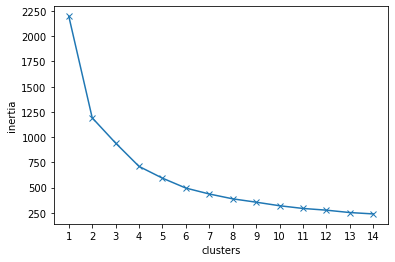

[2197.4105605683426,
 1191.4242595046408,
 941.4777150099358,
 710.2251749312632,
 593.9457593599827,
 495.66475146305174,
 437.0876930439308,
 389.13670486430544,
 355.98912166906206,
 320.8108035712594,
 293.90739850849906,
 276.8951174367185,
 253.312288327174,
 239.71850203786056]

In [24]:
plot_kmeans(X_pca, ['pc1', 'pc2'], 2, 15)

In [128]:
k = 8

In [26]:
def apply_kmeans(X, k, cols):
    X_cluster = X.copy()
    cl_df = X.loc[:,cols]
    
    km = KMeans(n_clusters = k).fit(cl_df)
    X_cluster["cluster"] = km.labels_

    return X_cluster

In [27]:
X_cluster = apply_kmeans(X_pca, k, ['pc1', 'pc2'])

In [28]:
X_cluster

,median danceability,median energy,median loudness,median speechiness,median acousticness,median liveness,median valence,median tempo,pc1,pc2,cluster
0,0.898907,0.112195,0.228545,0.763135,-0.187377,0.113333,-0.492806,0.545877,0.242526,-0.918813,2
1,0.262295,-0.531707,-0.531831,0.931094,-0.043393,-0.020000,-0.485612,-0.014315,-0.538789,-0.237923,5
2,-0.612022,-0.170732,-0.272488,-0.011197,0.015779,0.013333,-0.847122,0.011104,-0.464756,-0.286902,5
3,-0.306011,-0.085366,-0.116808,-0.195952,-0.269625,0.353333,-0.321942,-0.454062,0.025037,-0.333168,5
4,0.715847,-0.068293,0.411831,-0.004307,-0.286391,-0.173333,-0.803957,0.379425,-0.031009,-1.153019,2
...,...,...,...,...,...,...,...,...,...,...,...
784,-0.612022,1.414634,0.170704,-0.185185,-0.467574,0.493333,-0.419065,-0.197007,0.858470,-0.868151,2
785,-0.475410,-1.800000,-2.982723,-0.289406,2.142012,-0.133333,-0.023381,0.642404,-2.990849,2.207686,3
786,0.114754,-1.887805,-0.611643,-0.242894,1.266272,-0.326667,-0.455036,-0.923773,-1.911167,0.562431,1
787,-0.508197,0.331707,0.689014,-0.249785,-0.447337,-0.173333,-0.465827,0.013073,0.202455,-1.276409,2


In [30]:
ucl_df = pd.concat([df_artist, X_cluster.loc[:,['pc1', 'pc2', 'cluster']]], axis = 1)
ucl_df.head()

,artist,days,median danceability,median energy,median loudness,median speechiness,median acousticness,median liveness,median valence,median tempo,pc1,pc2,cluster
0,Migos,3227.0,0.8365,0.6690,-5.6810,0.15400,0.07950,0.1325,0.3505,137.4800,0.242526,-0.918813,2
1,Drake,6877.0,0.7200,0.5370,-7.7055,0.17350,0.11600,0.1225,0.3525,118.9900,-0.538789,-0.237923,5
2,The Weeknd,2926.0,0.5600,0.6110,-7.0150,0.06410,0.13100,0.1250,0.2520,119.8290,-0.464756,-0.286902,5
3,The Chainsmokers,2577.0,0.6160,0.6285,-6.6005,0.04265,0.05865,0.1505,0.3980,104.4755,0.025037,-0.333168,5
4,Rae Sremmurd,1147.0,0.8030,0.6320,-5.1930,0.06490,0.05440,0.1110,0.2640,131.9860,-0.031009,-1.153019,2


In [31]:
def plot_clusters(df_labeled, k):
    for i in range(k):
        pts = df_labeled.loc[df_labeled.cluster == i, :]
        plt.scatter(pts["pc1"], pts["pc2"], label = i)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title = 'cluster')
    plt.show()

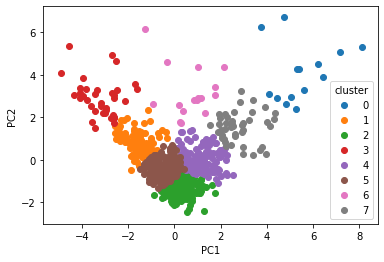

In [32]:
plot_clusters(ucl_df, k)

In [33]:
ucl_df.to_csv("TopCharts_clustered_artists.csv", index = False)

## Analysis

In [45]:
def top_artists(df, k, n):
    d = dict()
    for i in range(k):
        subset = df.loc[df.cluster == i, :].sort_values(by = "days", ascending = False)
        d[i] = list(subset.artist[:min(n, len(subset))])
    return d

In [48]:
top_artists(ucl_df, k, 5)

{0: ['Steve Aoki', 'John Lennon', 'Skrillex', 'Powfu', 'FRENSHIP'],
 1: ['XXXTENTACION',
  'Billie Eilish',
  'Khalid',
  'Sam Smith',
  'Childish Gambino'],
 2: ['Juice WRLD', 'Lil Uzi Vert', 'Travis Scott', 'Migos', 'Kodak Black'],
 3: ['Bing Crosby', 'TOTO', 'Frank Sinatra', 'Nat King Cole', 'Dean Martin'],
 4: ['Luke Combs', 'Eminem', 'DJ Khaled', 'Panic! At The Disco', 'Kanye West'],
 5: ['Post Malone', 'Drake', 'Ariana Grande', 'Kendrick Lamar', 'Ed Sheeran'],
 6: ['Lord Huron', 'Brenda Lee', 'Wham!', 'José Feliciano', 'The Jackson 5'],
 7: ['Lizzo', 'Famous Dex', 'Dustin Lynch', 'Lunay', 'Louis Tomlinson']}

### Top 50 most popular artists (by total # of days on top charts) vs not Top 50

In [114]:
top50 = ucl_df.sort_values(by = 'days', ascending = False).iloc[:50, :]
not_top50 = ucl_df.sort_values(by = 'days', ascending = False).iloc[50:, :]

In [115]:
top50.loc[:, ['artist', 'days', 'cluster']]

,artist,days,cluster
60,Post Malone,10513.0,5
171,XXXTENTACION,7221.0,1
1,Drake,6877.0,5
521,Billie Eilish,5180.0,1
141,Khalid,5066.0,1
520,Juice WRLD,4679.0,2
25,Lil Uzi Vert,4621.0,2
41,Travis Scott,4280.0,2
19,Ariana Grande,3518.0,5
165,Kendrick Lamar,3460.0,5


In [116]:
#looks like artists in clusters 2 and 5 tend to be the most popular (based on total number of days on top charts)
top50.cluster.value_counts()

5    32
2    12
1     4
4     2
Name: cluster, dtype: int64

In [132]:
print("proportion of artists in each cluster represented in top 50 most popular")
for i in range(k):
    n = len(top50.loc[top50.cluster == i])
    total = len(ucl_df.loc[ucl_df.cluster == i])
    print(f"{i}: {round(n/total,4)}")

proportion of artists in each cluster represented in top 50 most popular
0: 0.0
1: 0.0354
2: 0.0558
3: 0.0
4: 0.0175
5: 0.1345
6: 0.0
7: 0.0


In [117]:
from scipy.stats import ttest_ind

In [118]:
alpha = .05/8
print(f"bonferroni-corrected alpha = .05/8 = {alpha}\n")
for col in top50.columns[2:10]:
    print(f"difference in... average {col}")
    print(f"\th0: top 50 average {col} == not top 50 average {col}")
    print(f"\th1: top 50 average {col} != not top 50 average {col}\n")
    print(f"\ttop 50: {top50[col].mean()}\t\t\t not top 50:{not_top50[col].mean()}")
    tt = ttest_ind(top50[col], not_top50[col], equal_var = False)
    print(f"\tt = {tt[0]}")
    print(f"\tp = {tt[1]}")
    print(f"\tsignificant: {tt[1]<=alpha}\n")

bonferroni-corrected alpha = .05/8 = 0.00625

difference in... average median danceability
	h0: top 50 average median danceability == not top 50 average median danceability
	h1: top 50 average median danceability != not top 50 average median danceability

	top 50: 0.71203			 not top 50:0.6547895805142084
	t = 4.390489885903741
	p = 4.019974981218352e-05
	significant: True

difference in... average median energy
	h0: top 50 average median energy == not top 50 average median energy
	h1: top 50 average median energy != not top 50 average median energy

	top 50: 0.6035800000000001			 not top 50:0.6339536535859276
	t = -2.0660996428556624
	p = 0.04239875780411781
	significant: False

difference in... average median loudness
	h0: top 50 average median loudness == not top 50 average median loudness
	h1: top 50 average median loudness != not top 50 average median loudness

	top 50: -6.5164100000000005			 not top 50:-6.851160351826794
	t = 1.5539989020212266
	p = 0.12389663192923105
	significan

We can see the tests on differences in median danceability, acousticness, liveness, and valence of songs by the top 50 most popular artists (denoted as Group 1) are significantly different than those of songs by non-top 50 artists (denoted as Group 2). Specifically:
* Group 1 average median danceability > Group 2 average median danceability: Group 1 songs are significantly more dance-able/catchy/rhythmic 
* Group 1 average median acousticness < Group 2 average median acousticness: Group 1 songs are significantly less acoustic
* Group 1 average median liveness < Group 2 average median liveness: Group 1 songs are significantly less likely to have been performed live
* Group 1 average median valence < Group 2 average median valence: Group 1 songs are significantly less positive/happy (i.e. more negative)



In [122]:
c5_artists = ucl_df.loc[ucl_df.cluster == 5, :]
not_c5_artists = ucl_df.loc[ucl_df.cluster != 5, :]

In [123]:
alpha = .05/8
print(f"bonferroni-corrected alpha = .05/8 = {alpha}\n")
for col in c5_artists.columns[2:10]:
    print(f"difference in... average {col}")
    print(f"\th0: cluster 5 average {col} == not cluster 5 average {col}")
    print(f"\th1: cluster 5 average {col} != not cluster 5 average {col}\n")
    print(f"\ttop 50: {c5_artists[col].mean()}\t\t\t not top 50:{not_c5_artists[col].mean()}")
    tt = ttest_ind(c5_artists[col], not_c5_artists[col], equal_var = False)
    print(f"\tt = {tt[0]}")
    print(f"\tp = {tt[1]}")
    print(f"\tsignificant: {tt[1]<=alpha}\n")

bonferroni-corrected alpha = .05/8 = 0.00625

difference in... average median danceability
	h0: cluster 5 average median danceability == not cluster 5 average median danceability
	h1: cluster 5 average median danceability != not cluster 5 average median danceability

	top 50: 0.6784180672268907			 not top 50:0.6497776769509976
	t = 2.7764595862277286
	p = 0.005710368935523853
	significant: True

difference in... average median energy
	h0: cluster 5 average median energy == not cluster 5 average median energy
	h1: cluster 5 average median energy != not cluster 5 average median energy

	top 50: 0.600829831932773			 not top 50:0.6455049909255898
	t = -4.601153785573211
	p = 4.896721305836519e-06
	significant: True

difference in... average median loudness
	h0: cluster 5 average median loudness == not cluster 5 average median loudness
	h1: cluster 5 average median loudness != not cluster 5 average median loudness

	top 50: -6.82024369747899			 not top 50:-6.834137931034483
	t = 0.086466908

We can see the tests on differences in median danceability, energy, acousticness, liveness, and valence of songs by the artists in cluster 5 (denoted as Cluster 5) are significantly different than those of songs by artists in other clusters (Cluster O). Specifically:
* Cluster 5 average median danceability > Cluster O average median danceability: Cluster 5 songs are significantly more dance-able/catchy/rhythmic 
* Cluster 5 average median energy < Cluster O average median energy: Cluster 5 songs are significantly less intense/fast
* Cluster 5  average median acousticness < Cluster O average median acousticness: Cluster 5  songs are significantly less acoustic
* Cluster 5  average median liveness < Cluster O average median liveness: Cluster 5  songs are significantly less likely to have been performed live
* Cluster 5  average median valence < Cluster O average median valence: Cluster 5  songs are significantly less positive/happy (i.e. more negative)
